## Library Imports

In [87]:
library(glue)
library(rpart)
library(RColorBrewer)
library(randomForest)
library(caret)

options(repr.plot.width=10, repr.plot.height=5)

set.seed(20)
options(warn=-1)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



### Question 9.1

**Using the same crime data set uscrime.txt as in Question 8.2, apply Principal Component Analysis and then create a regression model using the first few principal components. Specify your new model in terms of the original variables (not the principal components), and compare its quality to that of your solution to Question 8.2. You can use the R function prcomp for PCA. (Note that to first scale the data, you can include scale. = TRUE to scale as part of the PCA function. Don’t forget that, to make a prediction for the new city, you’ll need to unscale the coefficients (i.e., do the scaling calculation in reverse)!)**

A few helper functions I need in order to evaluate the regression models are defined first.

The root mean squared error (RMSE) and the mean absolute error (MAE) functions are defined below. These functions will be used to understand the performance of the models. The lower the error the better the model.

In [3]:
# RMSE function
rmse <- function(resids) {
    sqrt(mean(resids^2))
}
# MAE function
mae <- function(resids) {
    mean(abs(resids))
}

The data is read in and defined as a data frame.

In [4]:
crime_data <- read.table('../data/9.1uscrimeSummer2018.txt', sep='', header=TRUE)

The sample data that the final model is going to be used to predict on is:

In [51]:
M  <-  14.0
So <- 0
Ed <- 10.0
Po1 <- 12.0
Po2 <- 15.5
LF <- 0.640
M.F <- 94.0
Pop <- 150
NW <- 1.1
U1 <- 0.120
U2 <- 3.6
Wealth <- 3200
Ineq <- 20.1
Prob <- 0.04
Time <- 39.0

sample_data <- data.frame(M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time)

From homework 3 question 8.2, the best performing model I found had the following formula:

Crime ~ M + Ed + Po1 + U2 + Ineq + Prob + Time

The model from question 8.2 is defined and evaluated below.

In [52]:
model_8 <- lm(formula=Crime ~ M + Ed + Po1 + U2 + Ineq + Prob + Time, data=crime_data)

sample_prediction <- round(predict(model_8, sample_data), 3)

print(glue("Prediction for the crime rate for the sample data is {sample_prediction}"))
print("Model from Question 8.2")
print(summary(model_8))

Prediction for the crime rate for the sample data is 1285.283
[1] "Model from Question 8.2"

Call:
lm(formula = Crime ~ M + Ed + Po1 + U2 + Ineq + Prob + Time, 
    data = crime_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-480.89  -89.12   -6.63  140.27  576.79 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4911.094    960.729  -5.112 8.79e-06 ***
M             106.659     33.877   3.148 0.003144 ** 
Ed            189.408     48.288   3.922 0.000345 ***
Po1           115.704     13.993   8.269 4.16e-10 ***
U2             88.720     41.364   2.145 0.038249 *  
Ineq           67.728     14.083   4.809 2.28e-05 ***
Prob        -4249.756   1880.672  -2.260 0.029502 *  
Time           -2.310      5.538  -0.417 0.678810    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 202.8 on 39 degrees of freedom
Multiple R-squared:  0.7669,	Adjusted R-squared:  0.7251 
F-statistic: 18.33 on 7 and 39 DF,  p-v

The model from 8.2 had an adjusted R-squared of 0.7251 and a residual standard error of 202.8. Also, the predicted crime rate for the fictional city was 1285.283. This will be the baseline to compare the PCA models too.

Perform scaling and PCA on the crime data.

In [53]:
pca_crime <- prcomp(crime_data[,-16], scale=TRUE)

# Grab just the transformed data
pca_data <- pca_crime$x
pca_data <- cbind(pca_data, Crime=crime_data$Crime)

How many components to use will be determined by testing a few different values. I'll use values between 3 and 6 components and evaluate each model with a 5 fold cross validation.

In order to limit the amount of results shown, I will calculate the RMSE and MAE for each model and only for the best model will I show the summary of the model.

In [54]:
for (n in 3:6) {
    # Shuffle data
    shuffled_df <- pca_data[sample(nrow(pca_data)), c(1:n, 16)]

    # 5 fold split
    folds <- cut(seq(1, nrow(pca_data)), breaks=5, labels=FALSE)

    # For each fold, train and test on Linear Regression algorithm
    resids <- c(1:nrow(pca_data))
    preds <- c(1:nrow(pca_data))
    for (i in 1:5) {
        test_indices <- which(folds==i, arr.ind=TRUE)
        test_data <- as.data.frame(shuffled_df[test_indices, ])
        train_data <- as.data.frame(shuffled_df[-test_indices, ])

        temp_fit <- lm(formula=Crime ~., data=train_data)

        # Perform prediction step on test data since model was fit using the training data
        preds[test_indices] <- predict(temp_fit, test_data)    
        resids[test_indices] <- test_data$Crime - preds[test_indices]
    }

    overall_rmse <- round(rmse(resids), 3)
    overall_mae <- round(mae(resids), 3)
    
    print(glue("{n}-Component PCA"))
    print(glue("RMSE: {overall_rmse}"))
    print(glue("MAE: {overall_mae}")) 
}

3-Component PCA
RMSE: 352.926
MAE: 281.825
4-Component PCA
RMSE: 350.955
MAE: 278.844
5-Component PCA
RMSE: 275.227
MAE: 222.131
6-Component PCA
RMSE: 273.053
MAE: 220.4


Based on the RMSE and MAE above, a 6-component PCA model is the best performing given a 5-fold CV. Using the full dataset, a final model with 6 components will be trained.

In [55]:
model_6_comp <- lm(formula=Crime ~ ., data=as.data.frame(pca_data[, c(1:6, 16)]))

# Transform the sample data into the same PCA vector space by first scaling the data
# around the center and the same scale range used when transforming the original dataset.
# Then multiply by the rotation.
sample_data_transformed <- scale(sample_data, pca_crime$center, pca_crime$scale) %*% pca_crime$rotation

sample_prediction_pca <- round(predict(model_6_comp, as.data.frame(t(sample_data_transformed[, 1:6]), 3)))

print(glue("Prediction for the crime rate for the sample data is {sample_prediction_pca}"))
print("6-Component PCA Model")
print(summary(model_6_comp))

Prediction for the crime rate for the sample data is 1248
[1] "6-Component PCA Model"

Call:
lm(formula = Crime ~ ., data = as.data.frame(pca_data[, c(1:6, 
    16)]))

Residuals:
    Min      1Q  Median      3Q     Max 
-377.15 -172.23   25.81  132.10  480.38 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   905.09      35.35  25.604  < 2e-16 ***
PC1            65.22      14.56   4.478 6.14e-05 ***
PC2           -70.08      21.35  -3.283  0.00214 ** 
PC3            25.19      25.23   0.998  0.32409    
PC4            69.45      33.14   2.095  0.04252 *  
PC5          -229.04      36.50  -6.275 1.94e-07 ***
PC6           -60.21      48.04  -1.253  0.21734    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 242.3 on 40 degrees of freedom
Multiple R-squared:  0.6586,	Adjusted R-squared:  0.6074 
F-statistic: 12.86 on 6 and 40 DF,  p-value: 4.869e-08



The adjusted R-squared was 0.6074 and the residual standard error was 242.3 which are both worse than the values for the model generated in question 8.2. Interestingly, the predicted crime rate was 1248 which was very similar to the 1285.283 value predicted by the model in question 8.2.

This shows that the componenets generated by PCA are not the best predictors when predicting crime rate. Using the original predictors give better results.

### Question 10.1


**Using the same crime data set uscrime.txt as in Questions 8.2 and 9.1, find the best model you can using**
1. a regression tree model, and
2. a random forest model.

**In R, you can use the tree package or the rpart package, and the randomForest package. For each model, describe one or two qualitative takeaways you get from analyzing the results (i.e., don’t just stop when you have a good model, but interpret it too).**

#### Regression Tree Model

For the regression tree model, I decided to use the rpart library to build the model. The original dataset without any feature selection was used. Also, the complexity parameter (CP) is used to prune the tree. The printcp() function shows the CP at each split in the tree.

My understanding of what this function is doing is that the tree is built out completely and then the tree is then pruned by removing the splits in data one by one. As each split is being removed, the CP is calculated. The CP has a minimum threshold of 0.01 and if the next split does not improve the R^2 value by 0.01 then the model is finished.

The model below ended up with 3 splits before hitting the 0.01 threshold value. At each split the cross-validated error (xerror) is calculated and the tree at which the minimum xerror is found is the optimal model to use.

In [22]:
tree <- rpart(formula=Crime ~., method="anova", data=crime_data)

printcp(tree)


Regression tree:
rpart(formula = Crime ~ ., data = crime_data, method = "anova")

Variables actually used in tree construction:
[1] NW  Po1 Pop

Root node error: 6880928/47 = 146403

n= 47 

        CP nsplit rel error xerror    xstd
1 0.362963      0   1.00000 1.0495 0.26921
2 0.148143      1   0.63704 1.1724 0.24786
3 0.051732      2   0.48889 1.2275 0.27769
4 0.010000      3   0.43716 1.2019 0.27894


Interestingly, only the NW, Pol and Pop features were used in creating the tree model. The optimal model, surprisingly, is when there is no split in the data.. Excluding this case leaves the tree with one split to have the lowest xerror value.

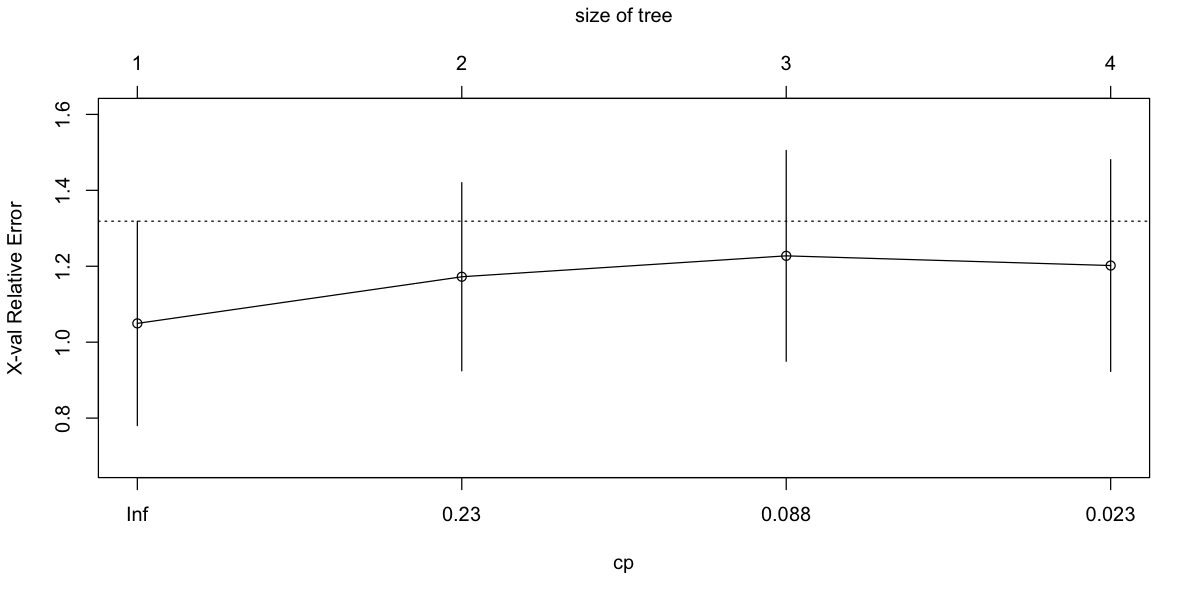

In [24]:
plotcp(tree)

The plotcp() function above plots the cross-validated error against the CP values from the tree model as its being pruned.

In [34]:
# prune the tree 
pfit<- prune(tree, cp=tree$cptable[which.min(tree$cptable[,"xerror"]),"CP"])

In [35]:
printcp(pfit)


Regression tree:
rpart(formula = Crime ~ ., data = crime_data, method = "anova")

Variables actually used in tree construction:
character(0)

Root node error: 6880928/47 = 146403

n= 47 

       CP nsplit rel error xerror    xstd
1 0.36296      0         1 1.0495 0.26921


Pruning the tree model so that the minimum xerror is used yields a single node with no split which is not very helpful.

The takeaways from this exercise is that a single decision tree is not very good at predicting something complicated like crime rate. Even with more splits in the data, the cross-validated error did not decrease which means the variation in the data is not properly accounted for in the model. 

#### Random Forest Model

The random forest algorithm was used with every predictor.

In [59]:
# Shuffle data
shuffled_df <- crime_data[sample(nrow(crime_data)),]

# 5 fold split
folds <- cut(seq(1, nrow(crime_data)), breaks=5, labels=FALSE)

# For each fold, train and test on RF algorithm
resids <- c(1:nrow(crime_data))
preds <- c(1:nrow(crime_data))
for (i in 1:5) {
    test_indices <- which(folds==i, arr.ind=TRUE)
    test_data <- as.data.frame(shuffled_df[test_indices, ])
    train_data <- as.data.frame(shuffled_df[-test_indices, ])

    temp_fit <- randomForest(formula=Crime ~., data=train_data)

    # Perform prediction step on test data since model was fit using the training data
    preds[test_indices] <- predict(temp_fit, test_data)    
    resids[test_indices] <- test_data$Crime - preds[test_indices]
    
    print(glue("Fold Number: {i}"))
    print(importance(temp_fit))
}

overall_rmse <- round(rmse(resids), 3)
overall_mae <- round(mae(resids), 3)

print(glue("RMSE: {overall_rmse}"))
print(glue("MAE: {overall_mae}")) 

Fold Number: 1
       IncNodePurity
M          91177.621
So          8420.084
Ed        105862.182
Po1       556680.976
Po2       513041.557
LF        125229.082
M.F        67854.648
Pop       432049.094
NW        253423.385
U1         90634.725
U2         96753.300
Wealth    408001.602
Ineq      101494.754
Prob      710772.143
Time      283103.346
Fold Number: 2
       IncNodePurity
M          183397.08
So          20368.92
Ed         193300.66
Po1       1084819.76
Po2        967155.71
LF         344948.39
M.F        264777.86
Pop        320945.27
NW         700732.17
U1         109479.21
U2         134470.84
Wealth     530953.04
Ineq       193848.47
Prob       669296.24
Time       178030.68
Fold Number: 3
       IncNodePurity
M          186292.21
So          19158.05
Ed         145769.43
Po1        905368.34
Po2        873145.60
LF         141066.78
M.F        313657.72
Pop        215304.27
NW         268758.21
U1          83337.07
U2          91243.93
Wealth     238473.49
Ineq      

The RMSE and the MAE are comparable to the model generated in question 9 using PCA and linear regression.

Looking at the importance of each predictor for each k-fold step, the predictors that show up most frequently are police protection investment (Po1 and Po2), probability of being imprisoned (prob), and median wealth (Wealth). These make sense since economic stability affects police funding, which in turn probably affects the number of people being imprisoned.

One thing I wish that random forest could show is the positive or negative correlation a predictor has with the response variable.

### Question 10.2

**Describe a situation or problem from your job, everyday life, current events, etc., for which a logistic regression model would be appropriate. List some (up to 5) predictors that you might use.**

**ANSWER:**

A situation where logistic regression might be useful in my everyday life is predicting the probability that I snooze my alarm in the morning before work. The 5 predictors that I might use to model this situation are:

1. How many hours did I sleep last night?
2. Is it the weekend or a weekday?
3. Do I have a meeting I cannot be late for?
4. Did I go out drinking last night?
5. Was yesterday an especially tiring day?

### Question 10.3

**1. Using the GermanCredit data set germancredit.txt from http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german / (description at http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29 ), use logistic regression to find a good predictive model for whether credit applicants are good credit risks or not. Show your model (factors used and their coefficients), the software output, and the quality of fit. You can use the glm function in R. To get a logistic regression (logit) model on data where the response is either zero or one, use family=binomial(link=”logit”) in your glm function call.**

In [71]:
german_data <- read.table('../data//10.3germancreditSummer2018_numeric.txt', sep='', header=FALSE)
german_data$V25 <- german_data$V25 - 1

Using a 5-fold cross-validation, the logistic regression algorithm was implemented with every predictor. The summary of the model at each fold in the cross-validation step is shown.

In [97]:
# Shuffle data
shuffled_df <- german_data[sample(nrow(german_data)),]

# 5 fold split
folds <- cut(seq(1, nrow(german_data)), breaks=5, labels=FALSE)

# For each fold, train and test on Linear Regression algorithm
resids <- c(1:nrow(german_data))
preds <- c(1:nrow(german_data))
for (i in 1:5) {
    test_indices <- which(folds==i, arr.ind=TRUE)
    test_data <- as.data.frame(shuffled_df[test_indices, ])
    train_data <- as.data.frame(shuffled_df[-test_indices, ])

    temp_fit <- glm(V25 ~., family=binomial(link='logit'), data=train_data)

    # Perform prediction step on test data since model was fit using the training data
    preds[test_indices] <- predict(temp_fit, newdata=test_data, type='response')
    print(glue("Fold number {i}"))
    print(summary(temp_fit))
}

binary_preds <- ifelse(preds > 0.5,1,0)

Fold number 1

Call:
glm(formula = V25 ~ ., family = binomial(link = "logit"), data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1716  -0.7298  -0.4182   0.8177   2.5710  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.570281   1.343636   2.657 0.007880 ** 
V1          -0.538473   0.078591  -6.852  7.3e-12 ***
V2           0.036298   0.009918   3.660 0.000252 ***
V3          -0.320909   0.099566  -3.223 0.001268 ** 
V4           0.003639   0.004372   0.832 0.405160    
V5          -0.184017   0.065455  -2.811 0.004933 ** 
V6          -0.168531   0.086785  -1.942 0.052145 .  
V7          -0.246720   0.124642  -1.979 0.047768 *  
V8          -0.009899   0.091469  -0.108 0.913817    
V9           0.148272   0.109908   1.349 0.177321    
V10         -0.018791   0.009674  -1.942 0.052083 .  
V11         -0.333398   0.125977  -2.646 0.008133 ** 
V12          0.172163   0.193264   0.891 0.373027    
V13          0.03

After the training and validation step, the final model using all available data is built.

In [109]:
final_model <- glm(V25 ~., family=binomial(link='logit'), data=german_data)

# Perform prediction step on test data since model was fit using the training data
final_preds <- predict(final_model, newdata=german_data, type='response')
print(summary(final_model))

binary_final_preds <- ifelse(final_preds > 0.5,1,0)


Call:
glm(formula = V25 ~ ., family = binomial(link = "logit"), data = german_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1675  -0.7082  -0.4129   0.7890   2.6220  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.231152   1.171518   2.758 0.005814 ** 
V1          -0.575461   0.071065  -8.098 5.60e-16 ***
V2           0.034089   0.008587   3.970 7.20e-05 ***
V3          -0.373500   0.086952  -4.295 1.74e-05 ***
V4           0.004294   0.003801   1.130 0.258535    
V5          -0.225906   0.059604  -3.790 0.000151 ***
V6          -0.145873   0.075689  -1.927 0.053945 .  
V7          -0.211760   0.114816  -1.844 0.065132 .  
V8           0.011961   0.081916   0.146 0.883906    
V9           0.167814   0.099152   1.692 0.090552 .  
V10         -0.009432   0.008478  -1.112 0.265925    
V11         -0.313985   0.110500  -2.841 0.004490 ** 
V12          0.208317   0.161724   1.288 0.197710    
V13          0.084091   0.2343

In [110]:
confusionMatrix(data = as.factor(binary_final_preds), as.factor(german_data$V25))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 629 144
         1  71 156
                                          
               Accuracy : 0.785           
                 95% CI : (0.7582, 0.8101)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 9.063e-10       
                                          
                  Kappa : 0.4498          
 Mcnemar's Test P-Value : 9.091e-07       
                                          
            Sensitivity : 0.8986          
            Specificity : 0.5200          
         Pos Pred Value : 0.8137          
         Neg Pred Value : 0.6872          
             Prevalence : 0.7000          
         Detection Rate : 0.6290          
   Detection Prevalence : 0.7730          
      Balanced Accuracy : 0.7093          
                                          
       'Positive' Class : 0               
                                          

The overall accuracy of the model is 78.5% and the most important predictors seem to be status of existing checking account, credit history, and credit amount.

**2. Because the model gives a result between 0 and 1, it requires setting a threshold probability to separate between “good” and “bad” answers. In this data set, they estimate that incorrectly identifying a bad customer as good, is 5 times worse than incorrectly classifying a good customer as bad. Determine a good threshold probability based on your model.**

Based on the confusion matrix above, there are 71 data points being misclassified as "bad" credit risks when they're actually "good" credit risks and 144 data points being misclassified as "good" credit risks when they're actually "bad" credit risks. So, the cost for this model becomes:

Cost = 71 x 1 + 144 x 5 = 791

I want to minimize this by removing as many false positives as possible without putting too many people into the false negative category. **Its important to note that the positive class is 0 in this case. This means I need a lower threshold value in order for a person to be classified as a "good" credit risk. If the positive class was 1 then I would need a higher threshold value.**

In [115]:
new_preds <- ifelse(final_preds > 0.2,1,0)
confusionMatrix(data = as.factor(new_preds), as.factor(german_data$V25))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 412  45
         1 288 255
                                          
               Accuracy : 0.667           
                 95% CI : (0.6368, 0.6962)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.9891          
                                          
                  Kappa : 0.3561          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.5886          
            Specificity : 0.8500          
         Pos Pred Value : 0.9015          
         Neg Pred Value : 0.4696          
             Prevalence : 0.7000          
         Detection Rate : 0.4120          
   Detection Prevalence : 0.4570          
      Balanced Accuracy : 0.7193          
                                          
       'Positive' Class : 0               
                                          